# fake news classifier

## import libraries

In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sys
import csv 
# increase field_size_limit to contain huge fields
csv.field_size_limit(sys.maxsize)

import tensorflow as tf 
print(tf.__version__)

import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer 

from tensorflow import keras
from keras.preprocessing.text import one_hot 
from keras_preprocessing.sequence import pad_sequences 

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout

from sklearn import metrics

import pickle

2.9.2


In [ ]:
# download nltk stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## read & explore dataset

In [ ]:
path_to_train_dataset = '/data/fake_news_data.csv'

In [ ]:
train_dataset = pd.read_csv(path_to_train_dataset, engine='python')

In [ ]:
df = train_dataset.copy()

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### about the dataset
the dataset includes 5 columns: 
- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
  - 1: unreliable
  - 0: reliable


In [ ]:
df.shape, df.columns

((20800, 5), Index(['id', 'title', 'author', 'text', 'label'], dtype='object'))

## data preprocessing

In [ ]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

the dataset contains roughly ~21k instances. 
but it's 'title' column contains 558 nan values, and it's 'text' column contains 39 null fields. 

since it is a text data, we cannot impute the data. so we drop the null values. 

In [ ]:
# drop null values
df = df.dropna()

In [ ]:
# get independent & dependent features 
X = df.drop('label', axis=1)
y = df['label']

In [ ]:
X.shape, y.shape

((18285, 4), (18285,))

In [ ]:
# determine if dataset is balanced
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [ ]:
# assign vocabulary size (hyperparameter)
voc_size = 10000

In [ ]:
texts = X.copy()

In [ ]:
texts.columns

Index(['id', 'title', 'author', 'text'], dtype='object')

In [ ]:
texts['title'][0:10]

0     House Dem Aide: We Didn’t Even See Comey’s Let...
1     FLYNN: Hillary Clinton, Big Woman on Campus - ...
2                     Why the Truth Might Get You Fired
3     15 Civilians Killed In Single US Airstrike Hav...
4     Iranian woman jailed for fictional unpublished...
5     Jackie Mason: Hollywood Would Love Trump if He...
7     Benoît Hamon Wins French Socialist Party’s Pre...
9     A Back-Channel Plan for Ukraine and Russia, Co...
10    Obama’s Organizing for Action Partners with So...
11    BBC Comedy Sketch "Real Housewives of ISIS" Ca...
Name: title, dtype: object

In [ ]:
# create a new Porter Stemmer
stemmer = PorterStemmer()
corpus = []

# remove stopwords & stemming & lower case 
# from second column: 'title'
for row in range(0, len(texts)):
  result = re.sub('[^a-zA-Z]', ' ', texts.iloc[row, 1]) # eliminate special characters
  result = result.lower() # lower case
  result = result.split()

  # stemming the words not present in English
  result = [stemmer.stem(word) for word in result if not word in stopwords.words('english')]
  result = ' '.join(result)
  corpus.append(result)

In [ ]:
corpus[0:20]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag',
 'russian research discov secret nazi militari base treasur hunter arctic photo',
 'us offici see link trump russia',
 'ye paid govern troll social media blog forum websit',
 'major leagu soccer argentin find home success new york time',
 'well fargo chief abruptli step new york time',
 'anonym donor pay million releas everyon arrest dakota access pipelin',
 'fbi close hilla

In [ ]:
# find out the top 10 longest sentences's length
sen_length = ([len(sentence.split()) for sentence in corpus])
print(sorted(sen_length, reverse=True)[0:9])

[47, 42, 31, 31, 29, 29, 27, 26, 26]


In [ ]:
# onehot encoding the features
onehot_corp = [one_hot(words, voc_size) for words in corpus]

In [ ]:
onehot_corp[0:5]

[[4039, 4705, 4407, 4900, 6304, 1513, 4965, 5424, 5307, 4970],
 [7910, 1195, 7130, 7033, 7306, 5810, 3038],
 [3104, 5766, 8340, 2952],
 [3243, 1318, 168, 3352, 2495, 3244],
 [7110, 7306, 5105, 1793, 2849, 9027, 7306, 2310, 9537, 1822]]

In [ ]:
# prepadding the corpus with 0s to fixed size 32
sentence_length = 32
embedded_corpus = pad_sequences(
    onehot_corp, padding='pre', maxlen=sentence_length
)

In [ ]:
embedded_corpus[0:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        4039, 4705, 4407, 4900, 6304, 1513, 4965, 5424, 5307, 4970],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 7910, 1195, 7130, 7033, 7306, 5810, 3038],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 3104, 5766, 8340, 2952],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 3243, 1318,  168, 3352, 2495, 3244],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   

## train test data prepration 

In [ ]:
# shape of input and output
print(len(embedded_corpus), y.shape)

18285 (18285,)


In [ ]:
X_final = np.array(embedded_corpus)
y_final = np.array(y)

In [ ]:
print(X_final.shape, y_final.shape)

(18285, 32) (18285,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.3, random_state=18
)

In [ ]:
# checking the class distribution of dataset
print('training set class distribution: ', '\n', 
      pd.DataFrame(y_train).value_counts(),'\n', 
      'test set class distribution: ','\n', pd.DataFrame(y_test).value_counts())

training set class distribution:  
 0    7205
1    5594
dtype: int64 
 test set class distribution:  
 0    3156
1    2330
dtype: int64


As shown above, the classes are evenly distributed.

## model creation


In [ ]:
# convert each word to a vector os size 128 (hyperparameter)
embedding_vec_input_features = 128

# create a 5 layers sequential model 
model = Sequential()
model.add(Embedding(
    voc_size, embedding_vec_input_features, input_length=sentence_length
))
model.add(Dropout(rate=0.3))
model.add(LSTM(units=128))
model.add(Dropout(rate=0.3))
# output layer for binary classification 
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.00005)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 128)           1280000   
                                                                 
 dropout (Dropout)           (None, 32, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


## model training


In [ ]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, batch_size=64)

Epoch 1/20
200/200 [==============================] - 30s 135ms/step - loss: 0.6649 - accuracy: 0.6400 - val_loss: 0.6269 - val_accuracy: 0.7197
Epoch 2/20
200/200 [==============================] - 21s 107ms/step - loss: 0.5576 - accuracy: 0.7562 - val_loss: 0.5028 - val_accuracy: 0.7743
Epoch 3/20
200/200 [==============================] - 23s 116ms/step - loss: 0.4523 - accuracy: 0.7937 - val_loss: 0.4274 - val_accuracy: 0.7838
Epoch 4/20
200/200 [==============================] - 27s 137ms/step - loss: 0.3739 - accuracy: 0.8305 - val_loss: 0.3458 - val_accuracy: 0.8369
Epoch 5/20
200/200 [==============================] - 27s 135ms/step - loss: 0.3120 - accuracy: 0.8633 - val_loss: 0.2976 - val_accuracy: 0.8675
Epoch 6/20
200/200 [==============================] - 26s 128ms/step - loss: 0.2676 - accuracy: 0.8900 - val_loss: 0.2639 - val_accuracy: 0.8841
Epoch 7/20
200/200 [==============================] - 23s 113ms/step - loss: 0.2346 - accuracy: 0.9034 - val_loss: 0.2366 - val_ac

In [ ]:
# save the model
file_name = 'fake_news_lstm_180620_01.sav'
path_to_save_model = file_name
pickle.dump(model, open(path_to_save_model, 'wb'))

## model evaluation 

In [ ]:
# load the saved model
file_name = 'fake_news_lstm_180620_01.sav'
path_to_save_model = file_name
loaded_model = pickle.load(open(path_to_save_model, 'rb'))

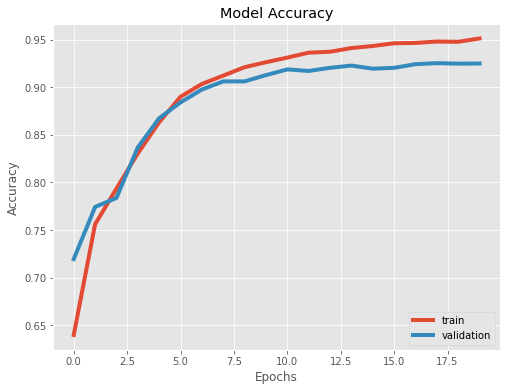

In [ ]:
# plot accuracy & validation accuracy of model
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
mpl.rcParams['lines.linewidth'] = 4
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

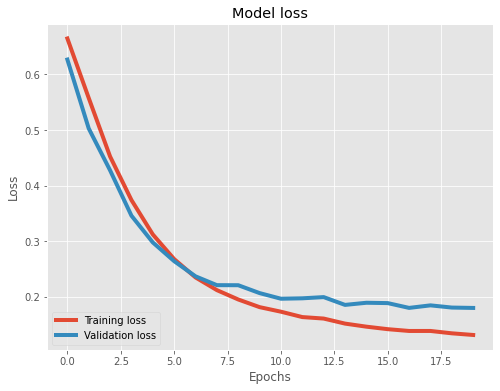

In [ ]:
# plot loss and validation loss of model
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
mpl.rcParams['lines.linewidth'] = 4
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='lower left')
plt.show()

As the first plot shows, the training accuracy exceeds 95% and the validation accuracy is about 92%. 

In addition the second plot shows that the loss for both training set and validation set keeps decreasing, however after the 5th epoch, the validation loss starts becoming steady. 


In [ ]:
# get predictions
y_preds = loaded_model.predict(X_test) 

172/172 [==============================] - 4s 22ms/step


In [ ]:
# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)

# calculate auc
auc = metrics.roc_auc_score(y_test, y_preds)

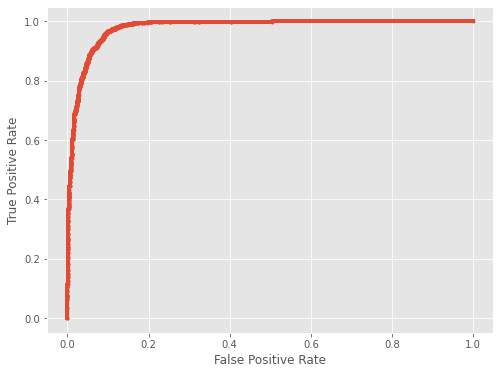

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
mpl.rcParams['lines.linewidth'] = 4
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The ROC curve above shows the trade-off between 'sensitivity' (TPR) and 'specifity' (FPR) for various thresholds. 

(more accurate choosing the right threshold requires domain knowledge)

As it's shown the graph is closer to the top-left corner, hence it indicates a good performance. 


In [ ]:
print('AUC: %.3f' % auc)

AUC: 0.979


AUC (Area Under Curve) is the measure of the ability of the classifier to distinguish between classes. The higher the AUC the better the performance of the model distinguishing between classes. Since the AUC of this model is close to 1, it is a good indication that the model performs well seperating 2 classes. 

In [ ]:
# convert probabilities of sigmoid to 
# binary (0, 1) with threshold 0.5
y_preds = np.where(y_preds > 0.5, 1, 0)

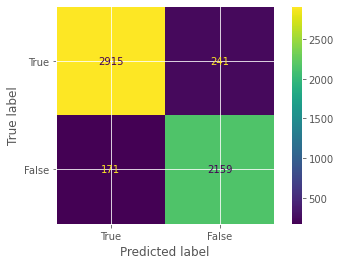

In [ ]:
# compute & plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=['True', 'False'])
cm_display.plot()
plt.show()

In [ ]:
print('---' * 6, 'classification report', '---' * 6)
print(metrics.classification_report(y_test, y_preds))

------------------ classification report ------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3156
           1       0.90      0.93      0.91      2330

    accuracy                           0.92      5486
   macro avg       0.92      0.93      0.92      5486
weighted avg       0.93      0.92      0.93      5486



The classification report shows the 'precision', 'recall' and 'f1-score' of the model. As it is shown, the model is performing well with 'macro average' score and 'weighted average' score of 92%. 